In [181]:


import matplotlib.pyplot as plt
import numpy as np
from cv2 import cv2 as cv
from scipy.optimize import fmin
from sklearn.cluster import KMeans

# Detect stones

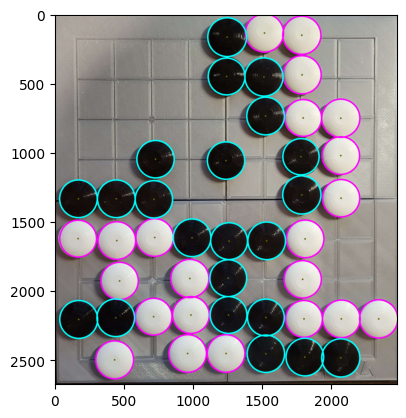

In [182]:
synthetic_board = False
path = '../data/board.png' if synthetic_board else '../data/board_real.jpg'
min_radius, max_radius = (0, 100) if synthetic_board else (100, 150)
min_dist = 50 if synthetic_board else 100
blur_size = 5 if synthetic_board else 11

img = cv.imread(path)

if not synthetic_board:
    img = img[150:-200, 300:-250]

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blurred = cv.medianBlur(gray, blur_size)

circles = cv.HoughCircles(blurred, cv.HOUGH_GRADIENT, 2, min_dist, param1=100, param2=100, minRadius=min_radius,
                          maxRadius=max_radius)

circles = np.uint16(np.around(circles)).squeeze()

circles_color = []
for c in circles:
    x, y, r = c
    x, y, r = int(x), int(y), int(r)
    bx, by = x - r, y - r
    bxx, byy = x + r, y + r

    bx = max(bx, 0)
    by = max(by, 0)

    px = blurred[by:byy, bx:bxx]
    is_white = np.mean(px) > 127
    circles_color.append(is_white)

for i, c in enumerate(circles):
    center = (c[0], c[1])
    radius = c[2]
    color = (255, 0, 255) if circles_color[i] else (255, 255, 0)

    cv.circle(img, center, 1, (0, 100, 100), 10)
    cv.circle(img, center, radius, color, 10)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

# Detect lines

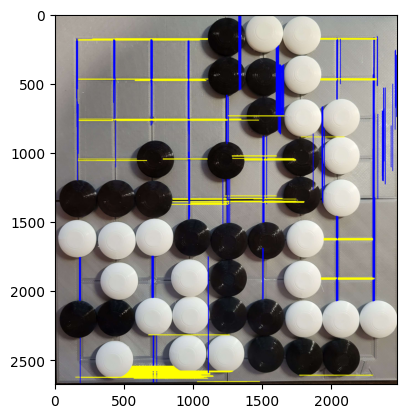

In [183]:
img = cv.imread(path)

if not synthetic_board:
    img = img[150:-200, 300:-250]

draw = np.zeros_like(img)
draw = np.copy(img)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# blurred = cv.medianBlur(gray, 3)
blurred = np.copy(gray)

edges = cv.Canny(blurred, 50, 200, None, 3)

linesP = cv.HoughLinesP(edges, 1, np.pi / 2, 100, None, 300, 100)

h_lines = []
v_lines = []
for i in range(0, len(linesP)):
    x1, y1, x2, y2 = linesP[i][0]
    dx, dy = x2 - x1, y2 - y1

    if np.sqrt(dx * dx + dy * dy) < 10:
        continue

    theta = np.arctan2(dy, dx)
    if 80 < np.rad2deg(abs(theta)) < 100:
        h_lines.append(linesP[i, 0])
        cv.line(draw, (x1, y1), (x2, y2), (255, 0, 0), 3, cv.LINE_AA)
    if np.rad2deg(abs(theta)) < 10 or np.rad2deg(abs(theta)) > 170:
        v_lines.append(linesP[i, 0])
        cv.line(draw, (x1, y1), (x2, y2), (0, 255, 255), 3, cv.LINE_AA)

h_lines = np.array(h_lines)
v_lines = np.array(v_lines)

plt.imshow(cv.cvtColor(draw, cv.COLOR_BGR2RGB))
plt.show()

# Merge lines

num h_lines 224
(2318, 0) (2318, 2674)
(181, 0) (181, 2674)


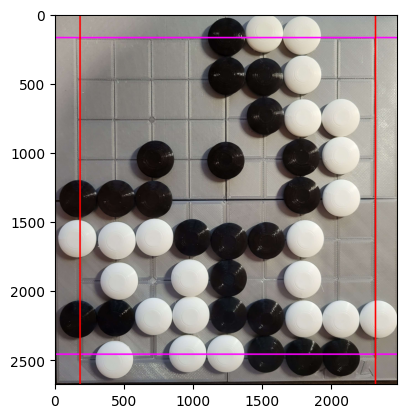

In [184]:
img = cv.imread(path)

if not synthetic_board:
    img = img[150:-200, 300:-250]

print(f'num h_lines {len(h_lines)}')


def to_rho_theta(line):
    x1, y1, x2, y2 = line.astype(float)
    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])
    d = p2 - p1
    n = d[::-1]
    n[0] *= -1
    if np.dot(-p1, n) < 0:
        n *= -1
    n /= np.linalg.norm(n)
    rho = np.dot(n, p1)
    theta = np.arctan2(d[1], d[0])
    if theta < 0:
        theta = abs(theta)
        rho *= -1
    return rho, theta


def to_positive_rho(line):
    rho, theta = line
    if rho < 0:
        rho = np.abs(rho)
        theta -= np.pi
    return rho, theta


def cluster_lines(img, lines):
    rows, cols, _ = img.shape
    max_rho = np.sqrt(rows ** 2 + cols ** 2)
    max_theta = np.pi

    # Normalize for clustering
    normalized = np.array(list(map(lambda x: (x[0] / max_rho, x[1] / max_theta), lines)))

    # Remove duplicate lines
    clusters = KMeans(n_clusters=15, n_init=15).fit(normalized)
    # TODO maybe use DBSCAN and filter out clusters that are not 90 deg from another one
    # TODO maybe check intra-cluster variance to determine if the clustering worked

    # Transform back to rho-theta space
    return list(map(lambda x: (x[0] * max_rho, x[1] * max_theta), clusters.cluster_centers_))


h_rho_theta_lines = list(map(lambda l: to_positive_rho(to_rho_theta(l)), h_lines))
h_merged_lines = cluster_lines(img, h_rho_theta_lines)
h_merged_lines = list(filter(lambda x: x[0] > 10 and x[0] < img.shape[0] - 10, h_merged_lines))

v_rho_theta_lines = list(map(lambda l: to_positive_rho(to_rho_theta(l)), v_lines))
v_merged_lines = cluster_lines(img, v_rho_theta_lines)
v_merged_lines = list(filter(lambda x: x[0] > 10 and x[0] < img.shape[1] - 10, v_merged_lines))

min_h_line = min(h_merged_lines, key=lambda x: x[0])
max_h_line = max(h_merged_lines, key=lambda x: x[0])
min_v_line = min(v_merged_lines, key=lambda x: x[0])
max_v_line = max(v_merged_lines, key=lambda x: x[0])

for rho, theta in [max_h_line, min_h_line]:
    pt1 = 0, int(rho)
    pt2 = img.shape[0], int(rho)
    cv.line(img, pt1, pt2, (255, 0, 255), 10, cv.LINE_AA)

for rho, theta in [max_v_line, min_v_line]:
    pt1 = int(rho), 0
    pt2 = int(rho), img.shape[0]
    print(pt1, pt2)
    cv.line(img, pt1, pt2, (0, 0, 255), 10, cv.LINE_AA)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

# Putting it all together

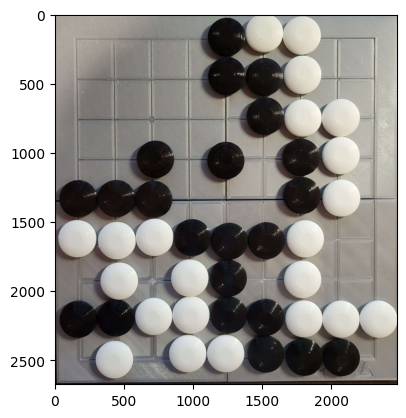

(2318, 0) (2318, 2674)
(181, 0) (181, 2674)
Optimization terminated successfully.
         Current function value: 280941.913719
         Iterations: 367
         Function evaluations: 666
142.82706718363443
[[0 0 0 0 1 2 0 1 0]
 [0 0 0 0 1 2 2 1 2]
 [0 0 0 1 1 2 0 2 0]
 [0 0 0 0 0 1 2 2 2]
 [1 1 0 1 0 1 1 1 2]
 [2 1 1 0 0 1 0 1 1]
 [2 2 2 1 1 2 2 2 1]
 [0 0 2 2 2 0 0 2 1]
 [0 0 0 0 0 0 0 2 0]]


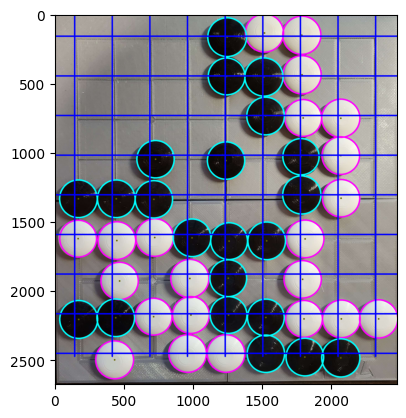

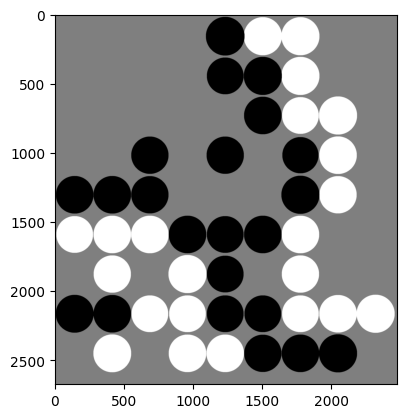

In [195]:
img = cv.imread(path)

if not synthetic_board:
    img = img[150:-200, 300:-250]

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

for i, c in enumerate(circles):
    center = (c[0], c[1])
    radius = c[2]
    color = (255, 0, 255) if circles_color[i] else (255, 255, 0)

    cv.circle(img, center, 1, (0, 100, 100), 10)
    cv.circle(img, center, radius, color, 10)

for rho, theta in [max_h_line, min_h_line]:
    pt1 = 0, int(rho)
    pt2 = img.shape[0], int(rho)
    # cv.line(img, pt1, pt2, (255, 0, 255), 10, cv.LINE_AA)

for rho, theta in [max_v_line, min_v_line]:
    pt1 = int(rho), 0
    pt2 = int(rho), img.shape[0]
    print(pt1, pt2)
    # cv.line(img, pt1, pt2, (0, 0, 255), 10, cv.LINE_AA)


def func(grid):
    sx, sy, w, h = grid
    loss = 0
    for x, y, r in circles:
        x, y = x - sx, y - sy
        gx, gy = x // w * w, y // h * h
        loss += abs(gx - x) ** 2 + abs(gy - y) ** 2
    return loss


x1, y1 = min_h_line[0], min_h_line[0]
x2, y2 = max_v_line[0], max_v_line[0]

gx, gy, gw, gh = fmin(func, [x1, y1, (x2 - x1) / 8 * 1, (y2 - y1) / 8 * 1])

print(gx)

for i in range(9):
    x, y = int(i * gw + gx), int(i * gh + gy)
    cv.line(img, (0, y), (img.shape[0], y), (255, 0, 0), 10)
    cv.line(img, (x, 0), (x, img.shape[1]), (255, 0, 0), 10)

board = np.zeros((9, 9), dtype=int)
draw = np.full_like(img, (127, 127, 127))
for i, (cx, cy, cr) in enumerate(circles):
    x, y = int((cx - gx + cr) // gw * gw + gx), int((cy - gy + cr) // gh * gh + gy)
    bi, bj = int((cx - gx + cr) // gw), int((cy - gy + cr) // gh)
    board[bi, bj] = 2 if circles_color[i] else 1
    cv.circle(draw, (x, y), cr, (255, 255, 255) if circles_color[i] else (0, 0, 0), -1)
print(board.T)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv.cvtColor(draw, cv.COLOR_BGR2RGB))
plt.show()